# Ames Housing - GAM (Generalized Additive Model)
- Author: Oliver Mueller
- Last update: 26.01.2024

## Initialize notebook
Load required packages. Set up workspace, e.g., set theme for plotting and initialize the random number generator.

In [5]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error

import pygam
from pygam import LinearGAM, s

In [6]:
# check numpy version
print(np.__version__)

1.26.3


In [7]:
pygam.__version__

'0.8.0'

In [3]:
plt.style.use('fivethirtyeight')

## Problem description

Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence. With 76 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this dataset challenges you to predict the final price of each home. More: <https://www.kaggle.com/c/house-prices-advanced-regression-techniques>


## Load data

Load training data from CSV file.

In [4]:
data = pd.read_csv('data/train.csv')

In [5]:
data.head()

,house_id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ThreeSsnPorch,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,20,RL,80,10400,Pave,none,Reg,Lvl,AllPub,...,0,0,0,MnPrv,0,6,2009,WD,Family,152000
1,2,60,RL,0,28698,Pave,none,IR2,Low,AllPub,...,0,225,0,none,0,6,2009,WD,Abnorml,185000
2,3,90,RL,70,9842,Pave,none,Reg,Lvl,AllPub,...,0,0,0,none,0,3,2007,WD,Normal,101800
3,4,90,RL,60,7200,Pave,none,Reg,Lvl,AllPub,...,0,0,0,none,0,6,2009,WD,Normal,90000
4,5,190,RM,63,7627,Pave,none,Reg,Lvl,AllPub,...,0,0,0,none,0,10,2009,WD,Normal,94550


In [6]:
data.shape

(2344, 78)

In [7]:
data.columns

Index(['house_id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea',
       'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', 'FirstFlrSF', 'SecondFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', '

## Prepare data

Let us first focus on some easy to understand variables.

In [8]:
data = data[["SalePrice", "LotArea", "GrLivArea", "FullBath", "BedroomAbvGr", "KitchenAbvGr", "OverallQual", "OverallCond"]]

In [9]:
data.head()

,SalePrice,LotArea,GrLivArea,FullBath,BedroomAbvGr,KitchenAbvGr,OverallQual,OverallCond
0,152000,10400,1370,2,3,1,7,5
1,185000,28698,2126,2,3,1,5,5
2,101800,9842,1224,2,2,2,4,5
3,90000,7200,1040,2,2,2,4,5
4,94550,7627,1701,2,4,2,4,6


Finally, we will split the data into features (*X*) and labels (*y*) and into training (*X_train, y_train*) and test (*X_test, y_test*) sets.

In [10]:
X = data.drop("SalePrice", axis=1)
y = data["SalePrice"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Fit a Generalized Additive Model

In [11]:
X_train.head()

,LotArea,GrLivArea,FullBath,BedroomAbvGr,KitchenAbvGr,OverallQual,OverallCond
2157,2522,1709,2,3,1,7,5
1831,19690,2201,2,4,1,6,7
564,11800,894,1,3,1,5,5
297,3072,1414,2,2,1,7,5
931,8000,1377,1,3,1,5,5


Unfortunately, the API of pyGAM is not very user-friendly. The following code illustrates how to fit a GAM with two smoothing spline terms (i.e., cubic splines with 2nd derivative smoothness constraints). The features have to be specified by using their column index (e.g., s(0, spline_order=3) refers to the first column of the feature matrix (LotArea)).

In [17]:
gam_mod = LinearGAM(s(0, spline_order=3) + s(1, spline_order=3))
gam_mod.fit(X_train, y_train)

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + s(1) + intercept, 
   tol=0.0001, verbose=False)

In the following, we will create partial dependence plots (incl. confidence intervals) for all terms of the model. 

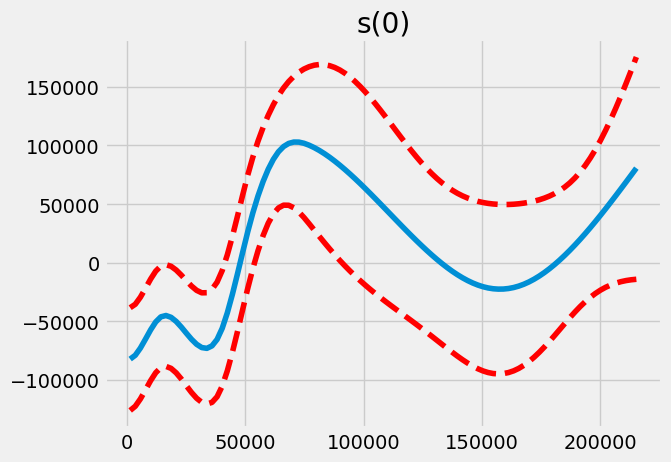

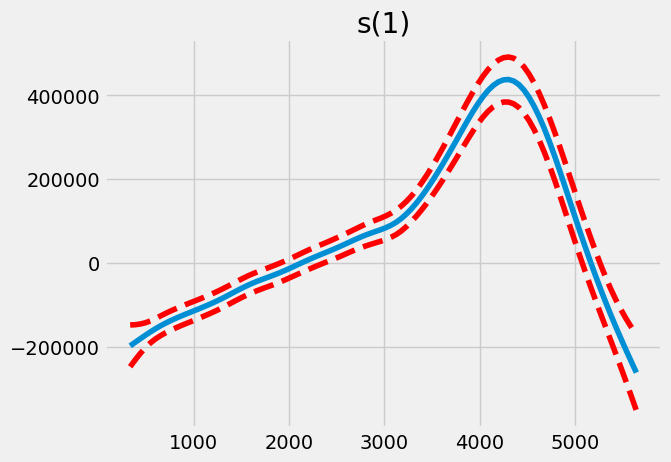

In [18]:
for i, term in enumerate(gam_mod.terms):
    if term.isintercept:
        continue

    XX = gam_mod.generate_X_grid(term=i)
    pdep, confi = gam_mod.partial_dependence(term=i, X=XX, width=0.95)

    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    plt.title(repr(term))
    plt.show()

If you seriouly want to use GAMs, I recommend to use the R package *mgcv*, which is much more powerful and user-friendly.